# Driver Performance Prediction
## Extract Data

In [1069]:
# pip install pandas
# pip install matplotlib
# pip install sqlite3
# pip install kaggle
# move kaggle.json file into ~/.kaggle (mac) or C:\Users<Windows-username>.kaggle\kaggle.json (windows)

import kaggle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 as db

dataset = "rohanrao/formula-1-world-championship-1950-2020"

kaggle.api.dataset_download_files(dataset, path='./', unzip=True)

print(f"Dataset {dataset} downloaded successfully!")

Dataset URL: https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020
Dataset rohanrao/formula-1-world-championship-1950-2020 downloaded successfully!


In [1070]:
results_df = pd.read_csv('results.csv')
qualifying_df = pd.read_csv('qualifying.csv')
lap_times_df = pd.read_csv('lap_times.csv')
pit_stops_df = pd.read_csv('pit_stops.csv')
driver_standings_df = pd.read_csv('driver_standings.csv')
driver_df = pd.read_csv('drivers.csv')
races_df = pd.read_csv('races.csv')
constructors_df = pd.read_csv('constructors.csv')
constructors_standings_df = pd.read_csv('constructor_standings.csv')
status_df = pd.read_csv('status.csv')

## Transform Data
Changing data types, dropping and renaming columns

In [1071]:

results_df.drop(['number', 'positionText', 'time', 'rank', 'fastestLap', 'fastestLapTime', 'fastestLapSpeed', 'laps', 'points', 'positionOrder', 'grid'], axis=1, inplace=True)

results_df.rename(columns={'position': 'final_position'}, inplace=True)

results_df['final_position'] = results_df['final_position'].replace('\\N', np.nan)
results_df.final_position = pd.to_numeric(results_df.final_position, errors='coerce')
results_df.milliseconds = pd.to_numeric(results_df.milliseconds, errors='coerce')
print(results_df.dtypes)
display(results_df)

resultId            int64
raceId              int64
driverId            int64
constructorId       int64
final_position    float64
milliseconds      float64
statusId            int64
dtype: object


,resultId,raceId,driverId,constructorId,final_position,milliseconds,statusId
0,1,18,1,1,1.0,5690616.0,1
1,2,18,2,2,2.0,5696094.0,1
2,3,18,3,3,3.0,5698779.0,1
3,4,18,4,4,4.0,5707797.0,1
4,5,18,5,1,5.0,5708630.0,1
...,...,...,...,...,...,...,...
26514,26520,1132,839,214,16.0,NaN,12
26515,26521,1132,815,9,17.0,NaN,12
26516,26522,1132,855,15,18.0,NaN,12
26517,26523,1132,847,131,NaN,NaN,34


In [1072]:
qualifying_df.drop(['number', 'q1', 'q2', 'q3', 'qualifyId'], axis=1, inplace=True)
qualifying_df.rename(columns={'position': 'qualifying_position'}, inplace=True)

print(qualifying_df.dtypes)
display(qualifying_df)

raceId                 int64
driverId               int64
constructorId          int64
qualifying_position    int64
dtype: object


,raceId,driverId,constructorId,qualifying_position
0,18,1,1,1
1,18,9,2,2
2,18,5,1,3
3,18,13,6,4
4,18,2,2,5
...,...,...,...,...
10249,1132,822,15,16
10250,1132,825,210,17
10251,1132,839,214,18
10252,1132,815,9,19


In [1073]:
lap_times_df.drop(['time', 'lap', 'position'], axis=1, inplace=True)
lap_times_df.rename(columns={'milliseconds': 'lap_time_milliseconds'}, inplace=True)

print(lap_times_df.dtypes)
display(lap_times_df)

raceId                   int64
driverId                 int64
lap_time_milliseconds    int64
dtype: object


,raceId,driverId,lap_time_milliseconds
0,841,20,98109
1,841,20,93006
2,841,20,92713
3,841,20,92803
4,841,20,92342
...,...,...,...
575024,1131,858,70742
575025,1131,858,70855
575026,1131,858,72454
575027,1131,858,73607


In [1074]:
pit_stops_df.drop(['duration', 'time', 'lap'], axis=1, inplace=True)
pit_stops_df.rename(columns={'milliseconds': 'stop_duration', 'stop':'pit_stop'}, inplace=True)

pit_stops_df.stop_duration = pd.to_numeric(pit_stops_df.stop_duration, errors='coerce')
print(pit_stops_df.dtypes)
display(pit_stops_df)

raceId           int64
driverId         int64
pit_stop         int64
stop_duration    int64
dtype: object


,raceId,driverId,pit_stop,stop_duration
0,841,153,1,26898
1,841,30,1,25021
2,841,17,1,23426
3,841,4,1,23251
4,841,13,1,23842
...,...,...,...,...
10985,1132,807,2,30265
10986,1132,840,2,29469
10987,1132,839,4,29086
10988,1132,815,4,28871


In [1075]:
driver_standings_df.drop(['position','positionText','driverStandingsId'], axis=1, inplace=True)
driver_standings_df.rename(columns={'points': 'driver_points', 'wins': 'driver_wins'}, inplace=True)

print(driver_standings_df.dtypes)
display(driver_standings_df)

raceId             int64
driverId           int64
driver_points    float64
driver_wins        int64
dtype: object


,raceId,driverId,driver_points,driver_wins
0,18,1,10.0,1
1,18,2,8.0,0
2,18,3,6.0,0
3,18,4,5.0,0
4,18,5,4.0,0
...,...,...,...,...
34590,1132,839,3.0,0
34591,1132,842,6.0,0
34592,1132,822,0.0,0
34593,1132,858,0.0,0


In [1076]:
driver_df['driver_name'] = driver_df['forename'] + ' ' + driver_df['surname']
driver_df.drop(['driverRef','number', 'code', 'dob', 'nationality', 'url', 'forename', 'surname'], axis=1, inplace=True)
driver_df.head()

,driverId,driver_name
0,1,Lewis Hamilton
1,2,Nick Heidfeld
2,3,Nico Rosberg
3,4,Fernando Alonso
4,5,Heikki Kovalainen


In [1077]:
races_df.drop(['date','time', 'round','url', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time'], axis=1, inplace=True)
races_df.rename(columns={'name': 'circuit_name'}, inplace=True)

print(races_df.dtypes)
display(races_df)

raceId           int64
year             int64
circuitId        int64
circuit_name    object
dtype: object


,raceId,year,circuitId,circuit_name
0,1,2009,1,Australian Grand Prix
1,2,2009,2,Malaysian Grand Prix
2,3,2009,17,Chinese Grand Prix
3,4,2009,3,Bahrain Grand Prix
4,5,2009,4,Spanish Grand Prix
...,...,...,...,...
1120,1140,2024,32,Mexico City Grand Prix
1121,1141,2024,18,São Paulo Grand Prix
1122,1142,2024,80,Las Vegas Grand Prix
1123,1143,2024,78,Qatar Grand Prix


In [1078]:
constructors_df.drop(['url', 'nationality', 'constructorRef'], axis=1, inplace=True)
constructors_df.rename(columns={'name': 'constructor_name'}, inplace=True)

print(constructors_df.dtypes)
display(constructors_df)

constructorId        int64
constructor_name    object
dtype: object


,constructorId,constructor_name
0,1,McLaren
1,2,BMW Sauber
2,3,Williams
3,4,Renault
4,5,Toro Rosso
...,...,...
207,210,Haas F1 Team
208,211,Racing Point
209,213,AlphaTauri
210,214,Alpine F1 Team


In [1079]:
constructors_standings_df.drop(['constructorStandingsId', 'position', 'positionText', 'wins'], axis=1, inplace=True)
constructors_standings_df.rename(columns={'points': 'constructor_points'}, inplace=True)

print(constructors_standings_df.dtypes)
display(constructors_standings_df)

raceId                  int64
constructorId           int64
constructor_points    float64
dtype: object


,raceId,constructorId,constructor_points
0,18,1,14.0
1,18,2,8.0
2,18,3,9.0
3,18,4,5.0
4,18,5,2.0
...,...,...,...
13266,1132,15,0.0
13267,1132,210,27.0
13268,1132,215,31.0
13269,1132,3,4.0


In [1080]:
print(status_df.dtypes)
display(status_df)

statusId     int64
status      object
dtype: object


,statusId,status
0,1,Finished
1,2,Disqualified
2,3,Accident
3,4,Collision
4,5,Engine
...,...,...
134,137,Damage
135,138,Debris
136,139,Illness
137,140,Undertray


In [1081]:
races_years = races_df['year'].unique()

lap_times_years = pd.merge(lap_times_df, races_df, on='raceId')['year'].unique()
pit_stops_years = pd.merge(pit_stops_df, races_df, on='raceId')['year'].unique()
qualifying_years = pd.merge(qualifying_df, races_df, on='raceId')['year'].unique()

races_years.sort(), lap_times_years.sort(), pit_stops_years.sort(), qualifying_years.sort()

(races_years, lap_times_years, pit_stops_years, qualifying_years)

(array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
        1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
        1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
        1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
        1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
        2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
        2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]),
 array([1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
        2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
        2018, 2019, 2020, 2021, 2022, 2023, 2024]),
 array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
        2022, 2023, 2024]),
 array([1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
        2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
        2016, 2017, 2018, 2019, 2020, 2021

## Merging data

In [1082]:
# merge datasets together


merge1_df = pd.merge(results_df, races_df, on='raceId', how='inner')
merge1_df = merge1_df.drop_duplicates(subset=['raceId', 'driverId'])

merge2_df = pd.merge(merge1_df, constructors_df, on='constructorId', how='inner')
merge2_df = merge2_df.drop_duplicates(subset=['raceId', 'driverId'])

merge3_df = pd.merge(merge2_df, constructors_standings_df, on=['raceId', 'constructorId'], how='inner')
merge3_df = merge3_df.drop_duplicates(subset=['raceId', 'driverId'])

merge4_df = pd.merge(merge3_df, driver_standings_df, on=['driverId', 'raceId'], how='inner')
merge4_df = merge4_df.drop_duplicates(subset=['raceId', 'driverId'])

merge5_df = pd.merge(merge4_df, driver_df, on=['driverId'])

merge6_df = pd.merge(merge5_df, lap_times_df, on=['driverId', 'raceId'], how='inner')
merge6_df = merge6_df.drop_duplicates(subset=['raceId', 'driverId'])

merge7_df = pd.merge(merge6_df, pit_stops_df, on=['driverId', 'raceId'], how='inner')
merge7_df = merge7_df.drop_duplicates(subset=['raceId', 'driverId'])

merge8_df = pd.merge(merge7_df, qualifying_df, on=['driverId', 'raceId'], how='inner')
merge8_df = merge8_df.drop_duplicates(subset=['raceId', 'driverId'])

combined_df = pd.merge(merge8_df, status_df, on='statusId', how='inner')
combined_df = combined_df.drop_duplicates(subset=['raceId', 'driverId'])

duplicates_check = combined_df.duplicated(subset=['raceId', 'driverId']).any()
print(duplicates_check)

display(combined_df)


False


,resultId,raceId,driverId,constructorId_x,final_position,milliseconds,statusId,year,circuitId,circuit_name,...,constructor_points,driver_points,driver_wins,driver_name,lap_time_milliseconds,pit_stop,stop_duration,constructorId_y,qualifying_position,status
0,20779,841,20,9,1.0,5370259.0,1,2011,1,Australian Grand Prix,...,35.0,25.0,1,Sebastian Vettel,98109,1,22603,9,1,Finished
1,20780,841,1,1,2.0,5392556.0,1,2011,1,Australian Grand Prix,...,26.0,18.0,0,Lewis Hamilton,100573,1,23227,1,2,Finished
2,20781,841,808,4,3.0,5400819.0,1,2011,1,Australian Grand Prix,...,15.0,15.0,0,Vitaly Petrov,102835,1,24535,4,6,Finished
3,20782,841,4,6,4.0,5402031.0,1,2011,1,Australian Grand Prix,...,18.0,12.0,0,Fernando Alonso,106144,1,23251,6,5,Finished
4,20783,841,17,9,5.0,5408430.0,1,2011,1,Australian Grand Prix,...,35.0,10.0,0,Mark Webber,101467,1,23426,9,3,Finished
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5300,26500,1131,822,15,16.0,NaN,11,2024,70,Austrian Grand Prix,...,0.0,0.0,0,Valtteri Bottas,80918,1,21918,15,18,+1 Lap
5301,26501,1131,855,15,17.0,NaN,11,2024,70,Austrian Grand Prix,...,0.0,0.0,0,Guanyu Zhou,84058,1,23198,15,20,+1 Lap
5302,26502,1131,4,117,18.0,NaN,11,2024,70,Austrian Grand Prix,...,58.0,41.0,0,Fernando Alonso,79908,1,21483,117,15,+1 Lap
5303,26503,1131,858,3,19.0,NaN,12,2024,70,Austrian Grand Prix,...,2.0,0.0,0,Logan Sargeant,84605,1,31722,3,19,+2 Laps


# Filter and drop nulls
Only show drivers who have finished a race

In [1083]:
combined_df.drop(['constructorId_y'], axis=1, inplace=True)
combined_df.rename(columns={'constructorId_x': 'constructorId'}, inplace=True)

df = combined_df[combined_df['status'] == 'Finished']

df = df.dropna()
df.isnull().sum()
display(df)

#df.to_csv('file1.csv')

,resultId,raceId,driverId,constructorId,final_position,milliseconds,statusId,year,circuitId,circuit_name,constructor_name,constructor_points,driver_points,driver_wins,driver_name,lap_time_milliseconds,pit_stop,stop_duration,qualifying_position,status
0,20779,841,20,9,1.0,5370259.0,1,2011,1,Australian Grand Prix,Red Bull,35.0,25.0,1,Sebastian Vettel,98109,1,22603,1,Finished
1,20780,841,1,1,2.0,5392556.0,1,2011,1,Australian Grand Prix,McLaren,26.0,18.0,0,Lewis Hamilton,100573,1,23227,2,Finished
2,20781,841,808,4,3.0,5400819.0,1,2011,1,Australian Grand Prix,Renault,15.0,15.0,0,Vitaly Petrov,102835,1,24535,6,Finished
3,20782,841,4,6,4.0,5402031.0,1,2011,1,Australian Grand Prix,Ferrari,18.0,12.0,0,Fernando Alonso,106144,1,23251,5,Finished
4,20783,841,17,9,5.0,5408430.0,1,2011,1,Australian Grand Prix,Red Bull,35.0,10.0,0,Mark Webber,101467,1,23426,3,Finished
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5292,26492,1131,825,210,8.0,5123153.0,1,2024,70,Austrian Grand Prix,Haas F1 Team,19.0,5.0,0,Kevin Magnussen,78826,1,21518,12,Finished
5293,26493,1131,817,215,9.0,5123967.0,1,2024,70,Austrian Grand Prix,RB F1 Team,30.0,11.0,0,Daniel Ricciardo,79507,1,21502,11,Finished
5294,26494,1131,842,214,10.0,5124564.0,1,2024,70,Austrian Grand Prix,Alpine F1 Team,9.0,6.0,0,Pierre Gasly,79109,1,21431,13,Finished
5295,26495,1131,844,6,11.0,5129854.0,1,2024,70,Austrian Grand Prix,Ferrari,291.0,150.0,1,Charles Leclerc,82085,1,31917,6,Finished


# Exploratory Data Analysis (EDA)

In [1084]:
print(df.dtypes)
display(df.describe())

resultId                   int64
raceId                     int64
driverId                   int64
constructorId              int64
final_position           float64
milliseconds             float64
statusId                   int64
year                       int64
circuitId                  int64
circuit_name              object
constructor_name          object
constructor_points       float64
driver_points            float64
driver_wins                int64
driver_name               object
lap_time_milliseconds      int64
pit_stop                   int64
stop_duration              int64
qualifying_position        int64
status                    object
dtype: object


,resultId,raceId,driverId,constructorId,final_position,milliseconds,statusId,year,circuitId,constructor_points,driver_points,driver_wins,lap_time_milliseconds,pit_stop,stop_duration,qualifying_position
count,2910.000000,2910.000000,2910.000000,2910.000000,2910.000000,2.910000e+03,2910.0,2910.000000,2910.000000,2910.000000,2910.000000,2910.000000,2.910000e+03,2910.000000,2.910000e+03,2910.000000
mean,23776.699656,988.818900,512.067698,60.548797,6.568385,5.997879e+06,1.0,2017.536770,25.406873,154.775086,78.653265,0.878007,1.156981e+05,1.029897,8.614528e+04,8.123711
std,1703.102460,88.456291,396.144270,77.930429,4.092934,1.187888e+06,0.0,4.095775,25.058640,163.245385,85.934114,2.124494,1.175132e+05,0.193037,3.371482e+05,5.417637
min,20779.000000,841.000000,1.000000,1.000000,1.000000,4.421143e+06,1.0,2011.000000,1.000000,0.000000,0.000000,0.000000,6.892200e+04,1.000000,1.636900e+04,1.000000
25%,22202.250000,903.000000,17.000000,6.000000,3.000000,5.350402e+06,1.0,2014.000000,7.000000,30.000000,15.000000,0.000000,9.606600e+04,1.000000,2.194250e+04,4.000000
50%,23833.500000,991.000000,815.000000,9.000000,6.000000,5.714258e+06,1.0,2018.000000,15.000000,95.000000,46.000000,0.000000,1.065960e+05,1.000000,2.360550e+04,7.000000
75%,25372.750000,1072.000000,832.000000,131.000000,9.000000,6.173550e+06,1.0,2021.000000,32.000000,238.000000,116.375000,1.000000,1.193085e+05,1.000000,2.605350e+04,12.000000
max,26496.000000,1131.000000,860.000000,215.000000,19.000000,1.474314e+07,1.0,2024.000000,80.000000,860.000000,575.000000,19.000000,2.483804e+06,3.000000,3.069017e+06,23.000000


#### Load into SQLite

In [1085]:
conn = db.connect('database.db')
cursor = conn.cursor()

df.to_sql('formula_one', conn, if_exists='replace')

2910

## Data Overview
### How many unique drivers, constructors (teams) and circuits are represented in the dataset

In [1086]:
unique_drivers = pd.read_sql_query('SELECT COUNT(DISTINCT driver_name) AS unique_drivers FROM formula_one', conn)
display(unique_drivers)

unique_constructors = pd.read_sql_query('SELECT COUNT(DISTINCT constructor_name) AS unique_constructors FROM formula_one', conn)
display(unique_constructors)

unique_circuits = pd.read_sql_query('SELECT COUNT(DISTINCT circuit_name) AS unique_circuits FROM formula_one', conn)
display(unique_circuits)

,unique_drivers
0,68


,unique_constructors
0,22


,unique_circuits
0,40


## Performance-based Analysis
### How does the qualifying position influence the final race position

,avg_qualifying_position,final_position
0,2.102941,1.0
1,3.588235,2.0
2,4.658088,3.0
3,5.468165,4.0
4,6.683398,5.0
5,7.678715,6.0
6,8.690583,7.0
7,10.064039,8.0
8,11.118919,9.0
9,11.987261,10.0


<Axes: xlabel='avg_qualifying_position', ylabel='final_position'>

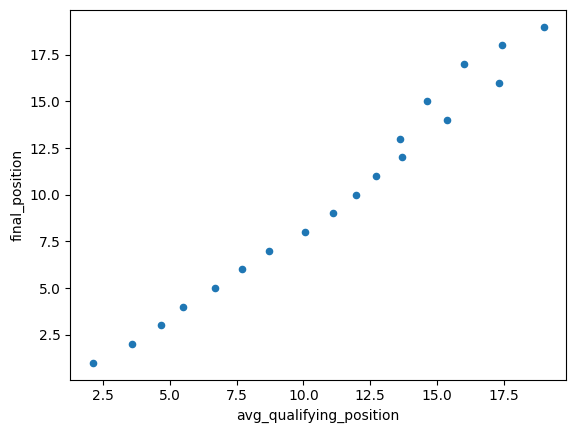

In [1087]:
qualifying_influence = pd.read_sql_query('SELECT AVG(qualifying_position) AS avg_qualifying_position, final_position FROM formula_one GROUP BY final_position', conn)

display(qualifying_influence)

qualifying_influence.plot(kind='scatter', x='avg_qualifying_position', y='final_position')

### Which drivers are the most consistent across races

In [1088]:
dftest = df.groupby(['driverId','driver_name'], as_index=False)['final_position'].std()
stdPosition = dftest.rename(columns={'final_position': 'std_position'})
stdPosition= stdPosition.sort_values(by='std_position')
stdPosition = stdPosition.dropna()
print(stdPosition)
# Dropped any values with NaN as a value because this indicates that the person has only raced once.
# The lower the std_position (closer to 0) indicates that they are more consistent, so in this case the most consistent drivers are brendon Hartley, and Jules Bianchi

    driverId       driver_name  std_position
50       843   Brendon Hartley      0.000000
35       824     Jules Bianchi      0.000000
52       845   Sergey Sirotkin      0.707107
30       819       Charles Pic      0.816497
7         10        Timo Glock      1.414214
..       ...               ...           ...
55       848   Alexander Albon      3.743758
28       817  Daniel Ricciardo      3.904548
22       808     Vitaly Petrov      3.968627
33       822   Valtteri Bottas      4.015610
63       856     Nyck de Vries      4.041452

[61 rows x 3 columns]


### Which drivers gain or lose the most position during races


,ID,Driver,Total_Races,Avg_diff
0,3,Nico Rosberg,95,-0.105263
1,15,Jarno Trulli,1,0.000000
2,857,Oscar Piastri,25,0.200000
3,17,Mark Webber,49,0.244898
4,844,Charles Leclerc,95,0.368421
...,...,...,...,...
63,834,Alexander Rossi,1,6.000000
64,820,Max Chilton,4,6.250000
65,831,Felipe Nasr,9,6.555556
66,843,Brendon Hartley,2,8.500000


,Driver,Avg_diff,Avg_final
0,Nico Rosberg,-0.105263,4.200000
1,Jarno Trulli,0.000000,19.000000
2,Oscar Piastri,0.200000,7.040000
3,Mark Webber,0.244898,4.020408
4,Charles Leclerc,0.368421,4.726316
...,...,...,...
63,Alexander Rossi,6.000000,12.000000
64,Max Chilton,6.250000,15.250000
65,Felipe Nasr,6.555556,8.666667
66,Brendon Hartley,8.500000,10.000000


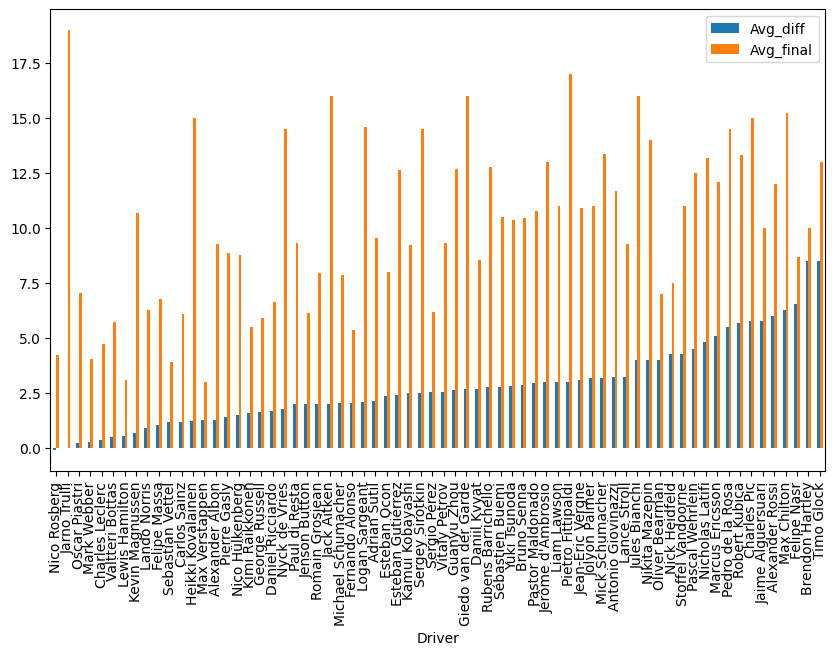

Correlation between Avg_diff and Avg_final: 0.41631141177248426


,ID,Driver,Total_Races,Avg_diff
0,10,Timo Glock,2,8.5


,ID,Driver,Total_Races,Avg_diff
0,3,Nico Rosberg,95,-0.105263


In [1089]:
# 68 unique drivers
# who has the highest and lowest sum(qualifying - final)?
## higher the difference, the more positions they are gaining, lower(especially negatives) the sum, more positions they are losing during the actual race

# show sum(qualifying - final) for each driver from each race participated
avg_diff = pd.read_sql_query("""
                            SELECT driverId AS ID, driver_name AS Driver, COUNT(raceId) AS Total_Races, AVG((qualifying_position - final_position)) as Avg_diff
                            FROM formula_one 
                            GROUP BY Driver
                            ORDER BY Avg_diff
                            """, conn)
display(avg_diff)

dff_fin = pd.read_sql_query("""
                                SELECT driver_name AS Driver, AVG((qualifying_position - final_position)) as Avg_diff, AVG(final_position) as Avg_final
                                FROM formula_one 
                                GROUP BY Driver
                                ORDER BY Avg_diff
                                """, conn)
display(dff_fin)

dff_fin.set_index('Driver', inplace=True)
ax = dff_fin.plot(kind="bar", figsize=(10, 6))
plt.show()

correlation = dff_fin['Avg_diff'].corr(dff_fin['Avg_final'])
print(f"Correlation between Avg_diff and Avg_final: {correlation}" )


max_diff = pd.read_sql_query("""
                             SELECT driverId AS ID, driver_name AS Driver, COUNT(raceId) AS Total_Races, AVG((qualifying_position - final_position)) as Avg_diff
                             FROM formula_one
                             GROUP BY Driver
                             ORDER BY Avg_diff DESC
                             LIMIT 1
                             """, conn)
display(max_diff)

min_diff = pd.read_sql_query("""
                             SELECT driverId AS ID, driver_name AS Driver, COUNT(raceId) AS Total_Races, AVG((qualifying_position - final_position)) as Avg_diff
                             FROM formula_one
                             GROUP BY Driver
                             ORDER BY Avg_diff ASC
                             LIMIT 1
                             """, conn)
display(min_diff)


### How does the average number of pit stops influence the final race position?

,avg_num_stops,final_position
0,1.000000,18.0
1,1.000000,19.0
2,1.011583,5.0
3,1.020080,6.0
4,1.022059,1.0
5,1.022059,2.0
6,1.022059,3.0
7,1.022472,4.0
8,1.026906,7.0
9,1.028571,11.0


<Axes: xlabel='avg_num_stops', ylabel='final_position'>

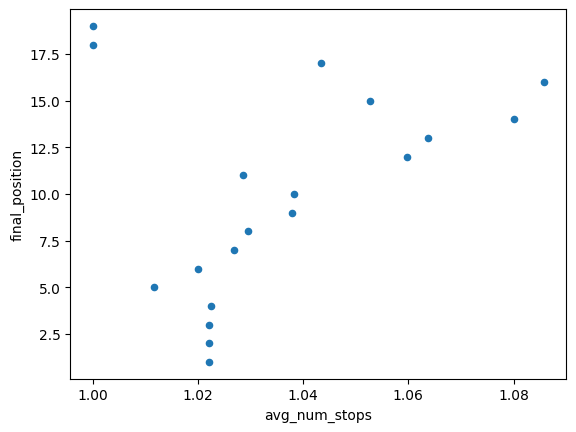

In [1090]:
num_stop_influence = pd.read_sql_query(
    """
    SELECT
        AVG(pit_stop) as avg_num_stops,
        final_position
    FROM 
        formula_one
    GROUP BY
        final_position
    ORDER BY
        avg_num_stops
    """, conn)
display(num_stop_influence)
num_stop_influence.plot(kind='scatter', x='avg_num_stops', y='final_position')

### How does accumulating points over a year influence the driver's final position?

,raceId,driverId,year,driver_points,final_position
0,860,818,2012,0.0,11.0
1,880,815,2013,0.0,11.0
2,948,835,2016,0.0,11.0
3,974,835,2017,0.0,11.0
4,989,815,2018,0.0,11.0
...,...,...,...,...,...
235,1121,830,2024,26.0,1.0
236,883,13,2013,30.0,15.0
237,974,815,2017,34.0,13.0
238,931,822,2015,42.0,14.0


<Axes: xlabel='driver_points', ylabel='final_position'>

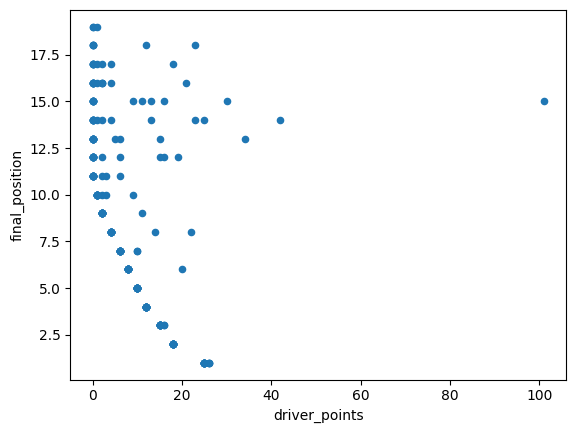

In [1091]:
points_influence = pd.read_sql_query(
    """
    SELECT
        raceId,
        driverId,
        year,
        driver_points,
        final_position
    FROM 
        formula_one
    GROUP BY
        final_position, year
    ORDER BY
        driver_points
    """, conn)
display(points_influence)
points_influence.plot(kind='scatter', x='driver_points', y='final_position')

### How does the constructor influence driver performance?

In [1092]:
constructor_influence = pd.read_sql_query('SELECT constructor_name, AVG(final_position) AS avg_final_position FROM formula_one GROUP BY constructor_name', conn)
display(constructor_influence)

,constructor_name,avg_final_position
0,Alfa Romeo,11.337662
1,AlphaTauri,9.753086
2,Alpine F1 Team,8.314607
3,Aston Martin,8.483516
4,Caterham,14.833333
5,Ferrari,4.609977
6,Force India,8.118343
7,HRT,17.000000
8,Haas F1 Team,11.213592
9,Lotus,18.500000


### How does the average lap times influence the driver’s final position?

,final_position,avg_lap_time,circuit,year
0,1.0,110984.0,Abu Dhabi Grand Prix,2011
1,2.0,113560.0,Abu Dhabi Grand Prix,2011
2,3.0,114263.0,Abu Dhabi Grand Prix,2011
3,4.0,114836.0,Abu Dhabi Grand Prix,2011
4,5.0,115291.0,Abu Dhabi Grand Prix,2011
...,...,...,...,...
2905,7.0,87073.0,Spanish Grand Prix,2024
2906,8.0,88615.0,Spanish Grand Prix,2024
2907,9.0,86584.0,Spanish Grand Prix,2024
2908,10.0,87460.0,Spanish Grand Prix,2024


<Axes: title={'center': 'Average Lap Time by Final Position at Spanish Grand Prix 2024'}, xlabel='avg_lap_time', ylabel='final_position'>

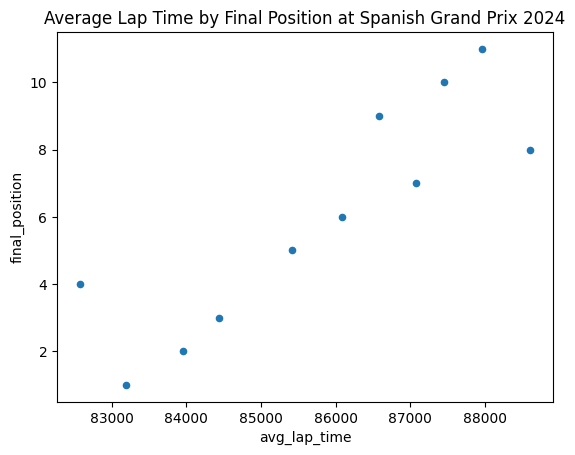

In [1093]:
#avg_lap_time_influence = pd.read_sql_query('SELECT AVG(lap_time_milliseconds) AS avg_lap_time, final_position FROM formula_one GROUP BY final_position', conn)
#display(avg_lap_time_influence)

avg_lap_time_influence = pd.read_sql_query('SELECT final_position AS final_position, AVG(lap_time_milliseconds) AS avg_lap_time, circuit_name AS circuit, year as year FROM formula_one GROUP BY circuit_name, year, final_position ORDER BY year',conn)
display(avg_lap_time_influence)

filtered_avg_lap_time = avg_lap_time_influence[(avg_lap_time_influence['circuit'] == 'Spanish Grand Prix') & (avg_lap_time_influence['year'] == 2024)]

filtered_avg_lap_time.plot(kind='scatter',x='avg_lap_time', y = 'final_position', title='Average Lap Time by Final Position at Spanish Grand Prix 2024') 

### Which drivers have the most consistent lap times per race

In [1094]:
data = pd.read_sql_query('SELECT circuit_name,driver_name, lap_time_milliseconds FROM formula_one', conn)

grouped_data = data.groupby(['driver_name','circuit_name']).agg(
    # lap_time_avg=('lap_time_milliseconds', 'mean'),  
    lap_time_standarddev=('lap_time_milliseconds', 'std') 
).reset_index()

grouped_data = grouped_data.sort_values(by='circuit_name')
grouped_data = grouped_data.dropna()

print(grouped_data)

             driver_name              circuit_name  lap_time_standarddev
619          Mark Webber      Abu Dhabi Grand Prix           1418.456203
645       Max Verstappen      Abu Dhabi Grand Prix          20418.968905
528         Lando Norris      Abu Dhabi Grand Prix           6387.393991
680   Michael Schumacher      Abu Dhabi Grand Prix           2141.119333
498         Lance Stroll      Abu Dhabi Grand Prix           7052.186966
...                  ...                       ...                   ...
983         Sergio Pérez  United States Grand Prix           7330.364088
679       Max Verstappen  United States Grand Prix           8708.440186
45       Alexander Albon  United States Grand Prix            630.394585
597       Lewis Hamilton  United States Grand Prix           6387.868332
1060        Yuki Tsunoda  United States Grand Prix           1701.298916

[625 rows x 3 columns]


### How does the average pit stop duration influence the driver’s final position?

,avg_stop_duration,final_position
0,22764.333333,19.0
1,26297.428571,18.0
2,35753.514286,16.0
3,42333.869565,17.0
4,62234.031915,13.0
5,67311.754386,15.0
6,70980.803419,12.0
7,72878.566879,10.0
8,74291.814286,11.0
9,78098.613900,5.0


<Axes: xlabel='avg_stop_duration', ylabel='final_position'>

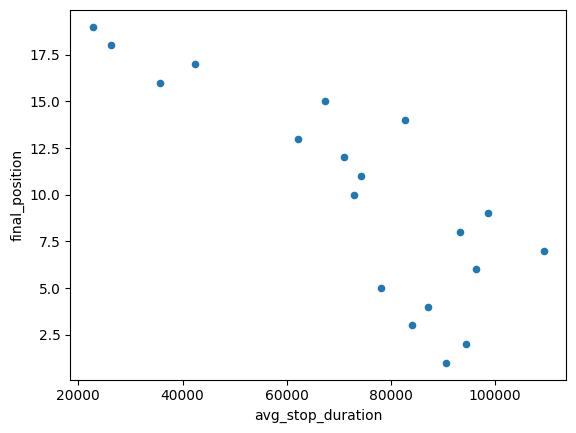

In [1095]:
stop_duration_influence = pd.read_sql_query(
    """
    SELECT
        AVG(stop_duration) AS avg_stop_duration,
        final_position
    FROM 
        formula_one
    GROUP BY
        final_position
    ORDER BY
        avg_stop_duration
    """, conn)
display(stop_duration_influence)
stop_duration_influence.plot(kind='scatter', x='avg_stop_duration', y='final_position')


### How does constructor points influence the final position of a driver?

,constructor_name,constructor_points,final_position
0,Red Bull,860.0,1.0
1,Red Bull,860.0,4.0
2,Red Bull,822.0,1.0
3,Red Bull,822.0,3.0
4,Red Bull,782.0,1.0
...,...,...,...
2905,Williams,0.0,17.0
2906,Lotus,0.0,18.0
2907,Caterham,0.0,18.0
2908,Williams,0.0,18.0


<Axes: xlabel='constructor_points', ylabel='final_position'>

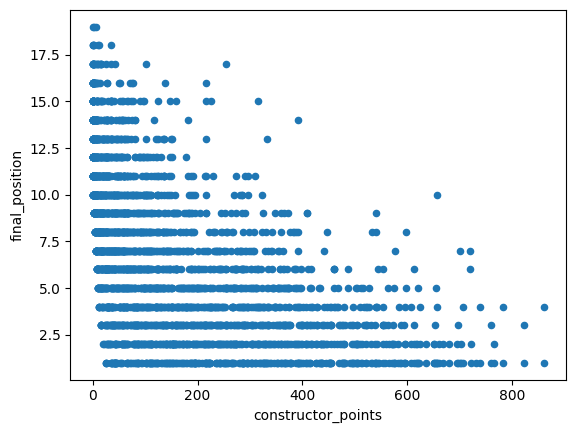

In [1096]:
constructor_points_influence = pd.read_sql_query('SELECT constructor_name, constructor_points, final_position FROM formula_one ORDER BY constructor_points DESC, final_position ASC;',conn)
display(constructor_points_influence)
constructor_points_influence.plot(kind='scatter', x='constructor_points', y='final_position')

### Are drivers with a higher number of wins more likely to achieve better final positions?

,driverId,driver_name,total_wins,final_position
0,1,Lewis Hamilton,89,1.0
1,830,Max Verstappen,60,1.0
2,20,Sebastian Vettel,43,1.0
3,3,Nico Rosberg,23,1.0
4,822,Valtteri Bottas,10,1.0
...,...,...,...,...
557,848,Alexander Albon,1,18.0
558,856,Nyck de Vries,1,18.0
559,15,Jarno Trulli,1,19.0
560,825,Kevin Magnussen,1,19.0


<Axes: xlabel='total_wins', ylabel='final_position'>

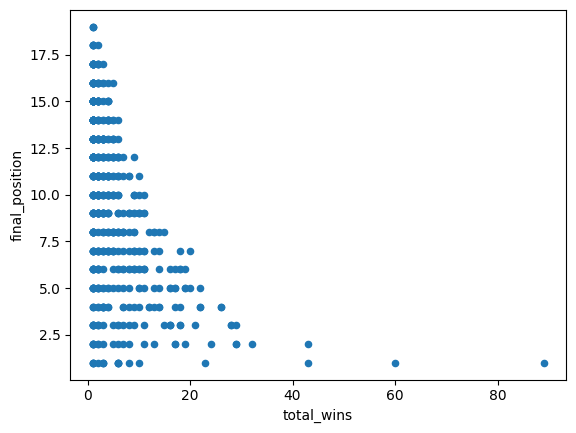

In [1097]:
driver_win_influence = pd.read_sql_query('SELECT driverId, driver_name, COUNT(driver_wins) as total_wins, final_position FROM formula_one GROUP BY driverId, driver_name, final_position ORDER BY final_position, total_wins DESC',conn)
display(driver_win_influence)
#driver_win_influence.to_csv('file1.csv')
driver_win_influence.plot(kind='scatter', x='total_wins', y='final_position')

### What are the strongest correlations between features and final race position?

In [1098]:
# Calculate correlations
qualifying_correlation = qualifying_influence['avg_qualifying_position'].corr(qualifying_influence['final_position'])
print("Average Qualifying Position: r =", qualifying_correlation)

avg_lap_time_correlation = avg_lap_time_influence['avg_lap_time'].corr(avg_lap_time_influence['final_position'])
print("Average Lap Time (in milliseconds): r =", avg_lap_time_correlation)

avg_num_stop_correlation = num_stop_influence['avg_num_stops'].corr(num_stop_influence['final_position'])
print("Average Number of Pit Stops: r =", avg_num_stop_correlation )

points_correlation = points_influence['driver_points'].corr(points_influence['final_position'])
print("Accumulated Driver Points in a Year: r =", points_correlation )

avg_stop_duration_correlation = stop_duration_influence['avg_stop_duration'].corr(stop_duration_influence['final_position'])
print("Average Pit Stop Duration (in milliseconds): r =", avg_stop_duration_correlation)

constructor_points_correlation = constructor_points_influence['constructor_points'].corr(constructor_points_influence['final_position'])
print("Constructor Points: r =", constructor_points_correlation)

driver_win_correlation = driver_win_influence['total_wins'].corr(driver_win_influence['final_position'])
print("Driver Wins: r =", constructor_points_correlation)

Average Qualifying Position: r = 0.9898726974297944
Average Lap Time (in milliseconds): r = 0.001278760366020096
Average Number of Pit Stops: r = 0.3117736197290106
Accumulated Driver Points in a Year: r = -0.42993678084472103
Average Pit Stop Duration (in milliseconds): r = -0.8157920240802379
Constructor Points: r = -0.5427439236067404
Driver Wins: r = -0.5427439236067404


### Find skewness and outliers

In [1099]:
conn.commit()
conn.close()

In [1100]:
df.skew(numeric_only=True)

resultId                 -0.065933
raceId                   -0.033792
driverId                 -0.447573
constructorId             0.956791
final_position            0.558803
milliseconds              3.168894
statusId                  0.000000
year                     -0.041627
circuitId                 1.159232
constructor_points        1.397599
driver_points             1.594343
driver_wins               3.567867
lap_time_milliseconds    19.341733
pit_stop                  7.135117
stop_duration             6.240939
qualifying_position       0.557269
dtype: float64

# Linear Regression

In [1101]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import LinearRegressionModel

 # create spark session
spark = SparkSession.builder.master("local").appName("Driver_Performance_Prediction").getOrCreate()

In [1102]:
spark.stop()